# Explore the Governance Data Set -- No Stemming
This notebook is a clone of the data cleaning notebook for the governance data set, but with stemming removed. It is an experiment to see what the word cloud looks like in such an instance.

---
## Installation and Dependencies
Here we install dependencies.

For text extraction from the Word documents we use [Antiword](https://pypi.org/project/antiword/), a text extraction front-end to Libreoffice. Your Notebook server should have [Libreoffice](https://www.libreoffice.org/) installed.

In [1]:
!pip install pymupdf filetype textract antiword wordcloud beautifulsoup4 unidecode

In [2]:
import re
import sys
import hashlib
from pathlib import Path
WRITE='w'
READ_BINARY='rb'
import multiprocessing
from multiprocessing import Pool
from collections import Counter
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import fitz
from fitz import VersionFitz as fitz__version__
print(f"pymupdf=={fitz__version__}")

import filetype
print(f"filetype=={filetype.__version__}")

import textract
from textract import VERSION as textract__version__
print(f"textract=={textract__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
print(f"nltk=={nltk.__version__}")

from bs4 import BeautifulSoup
from bs4 import __version__ as bs4__version__
print(f"beautifulsoup4=={bs4__version__}")

import chardet
print(f"chardet=={chardet.__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")

from unidecode import unidecode


python==3.10.9
pymupdf==1.22.0
filetype==1.2.0
textract==1.6.5
wordcloud==1.9.2
matplotlib==3.7.1
nltk==3.8.1
beautifulsoup4==4.8.2
chardet==3.0.4
pandas==2.0.1


In [3]:
# take any path and map it from the data directory to the cache directory.
def to_cache(path):
    return Path(str(path).replace('/data/', '/cache_no_stemming/'))

DATA_DIR = '../data/Governance'
CACHE_DIR = '../cache_no_stemming/Governance'
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

# The raw documents, warts and all; PDFs, ZIP files and Word documents.
GLOB_RAW_DOCUMENTS = DATA_DIR + '/GM????????.*'

# The files containing the extracted text from the raw documents.
GLOB_ALL_DOCUMENTS = CACHE_DIR + '/GM????????.txt'

GLOB_CA = CACHE_DIR + '/GM????CA??.txt'
GLOB_DV = CACHE_DIR + '/GM????DV??.txt'
GLOB_EX = CACHE_DIR + '/GM????EX??.txt'
GLOB_IK = CACHE_DIR + '/GM????IK??.txt'
GLOB_JS = CACHE_DIR + '/GM????JS??.txt'
GLOB_OB = CACHE_DIR + '/GM????OB??.txt'
GLOB_PB = CACHE_DIR + '/GM????PB??.txt'
GLOB_TV = CACHE_DIR + '/GM????TV??.txt'
GLOB_WS = CACHE_DIR + '/GM????WS??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"raw documents: {GLOB_RAW_DOCUMENTS}")
print(f"extracted documents = {GLOB_ALL_DOCUMENTS}")


raw documents: ../data/Governance/GM????????.*
extracted documents = ../cache_no_stemming/Governance/GM????????.txt


In [4]:
# The stopwords for the Dutch language. These come as downloadable sets with NLTK.
nltk.download('stopwords')
nltk.download('punkt')
dutch_stopwords = set(stopwords.words('dutch'))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def tokens_of(text):
    text = " ".join(text.splitlines())  # remove line endings and make the file one, huge string,
    text = unidecode(text)              # boil Unicode back to ASCII, removing accents,
    text = text.lower().strip()         # lowercase everything
                                        # and use only ascii, three+ letter sequences as tokens/words/terms
    return re.split('[^a-zA-Z]+', text)

def cleaned_text(from_file, text, stopwords):
    text = ' '.join([token for token in tokens_of(text) if (token not in stopwords) and (len(token) > 2)])
    if len(text) < 2048:
        print(f"suspiciously small file {from_file} has only {len(text)} characters")
    return text

def extract_pdf(from_file, to_file, stopwords):
    document = fitz.open(from_file)
    text = ""
    for page in document:
        text = text + " " + page.get_text('text')

    with open(to_file, WRITE) as f:
        text = cleaned_text(from_file, text, stopwords)
        f.write(text)
        f.write(' ')

def extract_msword(from_file, to_file, stopwords):
    with open(to_file, WRITE) as f:
        text = str(textract.process(str(from_file)))
        text = cleaned_text(from_file, text, stopwords)
        f.write(text)

def encoding_of(file):
    rawdata = open(file, "rb").read()
    if len(rawdata) == 0:
        return 'ascii'
    encoding = chardet.detect(rawdata)['encoding']
    print(f"loading {file} using {encoding} encoding")
    return encoding

def extract_plain(from_file, to_file, stopwords):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            text = cleaned_text(from_file, text, stopwords)
            f.write(text)

# https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python

def extract_html(from_file, to_file, stopwords):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            soup = BeautifulSoup(text, features="html.parser")
            # r=ip out script and style elements as these would pollute the text
            for script in soup(["script", "style"]):
                script.extract()
            text = soup.get_text()
            
            text = cleaned_text(from_file, text, stopwords)
            f.write(text)

def extract_file(from_file):
    mime_type = filetype.guess_mime(from_file)
    to_file = to_cache(from_file.with_suffix('.txt'))

    if to_file.exists():
        pass
    elif from_file.stem == 'GM1711OB02':
        print(f"ignoring {from_file} as it is of MIME type text/css")
    elif mime_type == "application/pdf":
        extract_pdf(from_file, to_file, dutch_stopwords)
    elif mime_type == "application/vnd.openxmlformats-officedocument.wordprocessingml.document" or \
         mime_type == "application/msword":
        extract_msword(from_file, to_file, dutch_stopwords)
    elif not mime_type:
        if from_file.suffix.lower() == '.txt':
            extract_plain(from_file, to_file, dutch_stopwords)
        if from_file.suffix.lower() == '.zip':
            # seems wrong, but it is correct for our data...
            extract_html(from_file, to_file, dutch_stopwords)
    else:
        raise Exception(f"don't known how to handle {from_file} of MIME type {mime_type}")

def extract_dir(glob):
     with Pool(multiprocessing.cpu_count() + 1) as p:
        p.map(extract_file, [file for file in expand_glob(glob)])


In [6]:
extract_dir(GLOB_RAW_DOCUMENTS)

suspiciously small file ../data/Governance/GM0173IK01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0085IK01.pdf has only 0 characterssuspiciously small file ../data/Governance/GM0140IK01.pdf has only 0 characters

suspiciously small file ../data/Governance/GM0275CA01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0180OB04.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0056CA01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0214CA01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0014OB04.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0277PB01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0147CA02.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0147CA03.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0252OB01.pdf has only 0 characters
ignoring ../data/Governance/GM0147PB02.z

In [7]:
# https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file

def md5(file):
    hash_md5 = hashlib.md5()
    with open(file, READ_BINARY) as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def delete_duplicates(glob):
    hashes = set()
    dupes = 0
    for file in expand_glob(glob):
        hash = md5(file)
        if hash in hashes:
            print(f"deleting {file} as dupe")
            file.unlink()
            dupes += 1
        else:
            hashes.add(hash)
    print(f"deleted {dupes} duplicates")

In [8]:
delete_duplicates(GLOB_ALL_DOCUMENTS)

deleting ../cache_no_stemming/Governance/GM0014OB04.txt as dupe
deleting ../cache_no_stemming/Governance/GM0056CA01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0059IK01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0063CA02.txt as dupe
deleting ../cache_no_stemming/Governance/GM0063CA03.txt as dupe
deleting ../cache_no_stemming/Governance/GM0063JS01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0079EX01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0079IK01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0085IK01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0086CA02.txt as dupe
deleting ../cache_no_stemming/Governance/GM0093DV01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0140IK01.txt as dupe
deleting ../cache_no_stemming/Governance/GM0147CA02.txt as dupe
deleting ../cache_no_stemming/Governance/GM0147CA03.txt as dupe
deleting ../cache_no_stemming/Governance/GM0148CA01.txt as dupe
deleting ../cache_no_stemming/Governance

In [9]:
def make_word_cloud(glob):
    corpus = ""
    for file in expand_glob(glob):
        corpus = corpus + " " + file.read_text()

    cloud = WordCloud(background_color="white", max_words=50).generate(corpus)
    plt.axis('off')
    plt.imshow(cloud);


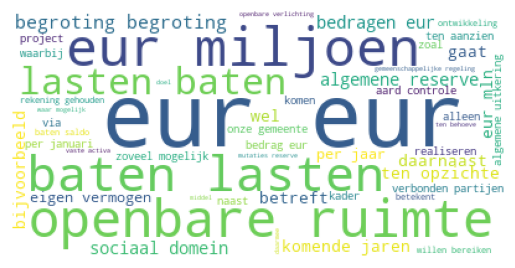

In [10]:
make_word_cloud(GLOB_ALL_DOCUMENTS)


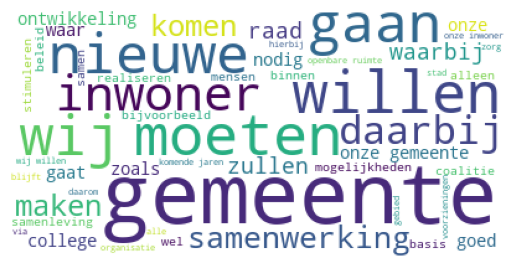

In [11]:
make_word_cloud(GLOB_CA)


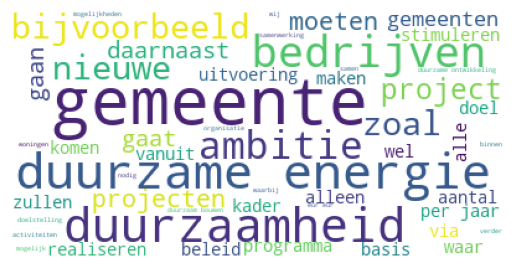

In [12]:
make_word_cloud(GLOB_DV)


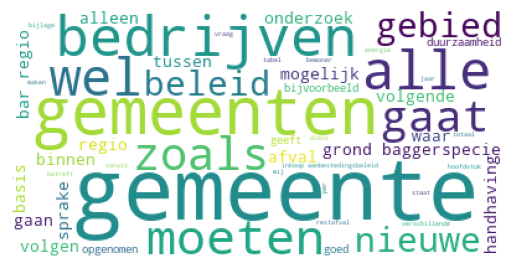

In [13]:
make_word_cloud(GLOB_EX)


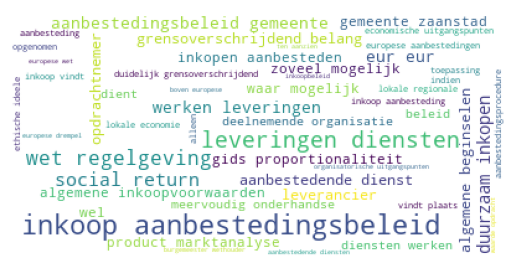

In [14]:
make_word_cloud(GLOB_IK)


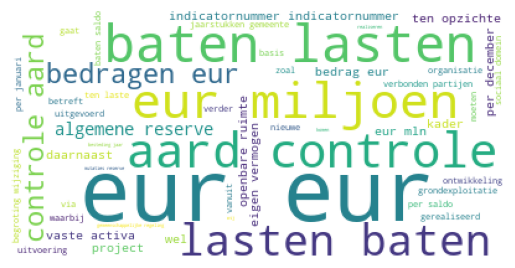

In [15]:
make_word_cloud(GLOB_JS)


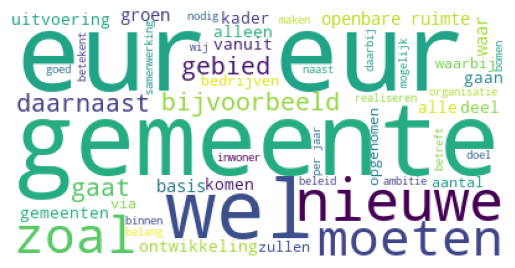

In [16]:
make_word_cloud(GLOB_OB)


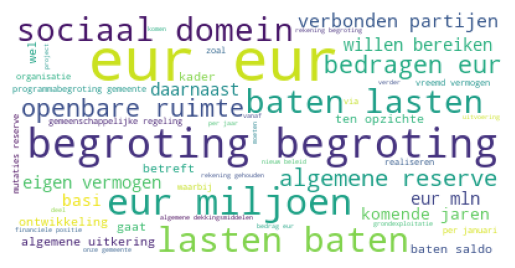

In [17]:
make_word_cloud(GLOB_PB)


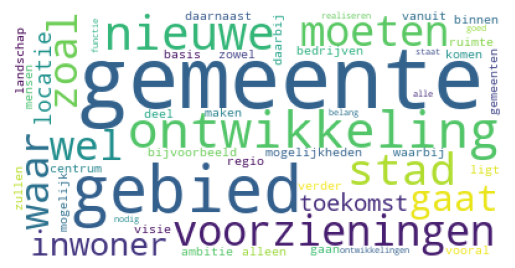

In [18]:
make_word_cloud(GLOB_TV)


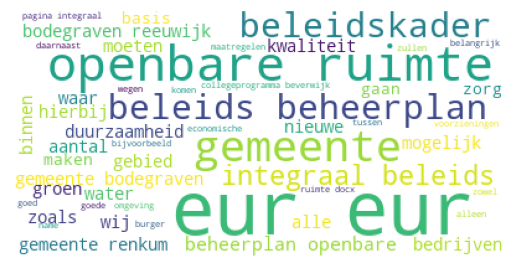

In [19]:
make_word_cloud(GLOB_WS)
